Introduction

With the advancement in deep learning, neural network architectures like recurrent neural networks (RNN and LSTM) and convolutional neural networks (CNN) have shown a decent improvement in performance in solving several Natural Language Processing (NLP) tasks like text classification, language modeling, machine translation, etc.

However, this performance of deep learning models in NLP pales in comparison to the performance of deep learning in Computer Vision.

One of the main reasons for this slow progress could be the lack of large labeled text datasets. Most of the labeled text datasets are not big enough to train deep neural networks because these networks have a huge number of parameters and training such networks on small datasets will cause overfitting.

Another quite important reason for NLP lagging behind computer vision was the lack of transfer learning in NLP. Transfer learning has been instrumental in the success of deep learning in computer vision. This happened due to the availability of huge labeled datasets like Imagenet on which deep CNN based models were trained and later they were used as pre-trained models for a wide range of computer vision tasks.

That was not the case with NLP until 2018 when the transformer model was introduced by Google. Ever since the transfer learning in NLP is helping in solving many tasks with state of the art performance.

Transfer Learning in NLP:

Transfer learning is a technique where a deep learning model trained on a large dataset is used to perform similar tasks on another dataset. We call such a deep learning model a pre-trained model. The most renowned examples of pre-trained models are the computer vision deep learning models trained on the ImageNet dataset. So, it is better to use a pre-trained model as a starting point to solve a problem rather than building a model from scratch.

Soon a wide range of transformer-based models started coming up for different NLP tasks. There are multiple advantages of using transformer-based models, but the most important ones are:

First Benefit
These models do not process an input sequence token by token rather they take the entire sequence as input in one go which is a big improvement over RNN based models because now the model can be accelerated by the GPUs.

2nd Benefit
We don’t need labeled data to pre-train these models. It means that we have to just provide a huge amount of unlabeled text data to train a transformer-based model. We can use this trained model for other NLP tasks like text classification, named entity recognition, text generation, etc. This is how transfer learning works in NLP.

BERT and GPT-2 are the most popular transformer-based models and in this article, we will focus on BERT and learn how we can use a pre-trained BERT model to perform text classification.

What is Model Fine-Tuning?


BERT (Bidirectional Encoder Representations from Transformers) is a big neural network architecture, with a huge number of parameters, that can range from 100 million to over 300 million. So, training a BERT model from scratch on a small dataset would result in overfitting.

So, it is better to use a pre-trained BERT model that was trained on a huge dataset, as a starting point. We can then further train the model on our relatively smaller dataset and this process is known as model fine-tuning.

Different Fine-Tuning Techniques
Train the entire architecture – We can further train the entire pre-trained model on our dataset and feed the output to a softmax layer. In this case, the error is back-propagated through the entire architecture and the pre-trained weights of the model are updated based on the new dataset.
Train some layers while freezing others – Another way to use a pre-trained model is to train it partially. What we can do is keep the weights of initial layers of the model frozen while we retrain only the higher layers. We can try and test as to how many layers to be frozen and how many to be trained.
Freeze the entire architecture – We can even freeze all the layers of the model and attach a few neural network layers of our own and train this new model. Note that the weights of only the attached layers will be updated during model training.
In this tutorial, we will use the third approach. We will freeze all the layers of BERT during fine-tuning and append a dense layer and a softmax layer to the architecture.

Overview of BERT:

You’ve heard about BERT, you’ve read about how incredible it is, and how it’s potentially changing the NLP landscape. But what is BERT in the first place?

Here’s how the research team behind BERT describes the NLP framework:

“BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.”

That sounds way too complex as a starting point. But it does summarize what BERT does pretty well so let’s break it down.

Firstly, BERT stands for Bidirectional Encoder Representations from Transformers. Each word here has a meaning to it and we will encounter that one by one in this article. For now, the key takeaway from this line is – BERT is based on the Transformer architecture. Secondly, BERT is pre-trained on a large corpus of unlabelled text including the entire Wikipedia (that’s 2,500 million words!) and Book Corpus (800 million words).

This pre-training step is half the magic behind BERT’s success. This is because as we train a model on a large text corpus, our model starts to pick up the deeper and intimate understandings of how the language works. This knowledge is the swiss army knife that is useful for almost any NLP task.

Third, BERT is a “deep bidirectional” model. Bidirectional means that BERT learns information from both the left and the right side of a token’s context during the training phase.



In [46]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel , BertTokenizerFast

#specify GPU
device = torch.device('cuda')

You would have to upload the downloaded spam dataset to your Colab runtime. Then read it into a pandas dataframe.



In [48]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


The dataset consists of two columns – “label” and “text”. The column “text” contains the message body and the “label” is a binary variable where 1 means spam and 0 means the message is not a spam.

Now we will split this dataset into three sets – train, validation, and test.

In [49]:
# split train dataset into train, validation and test sets

train_text , temp_text , train_labels , temp_labels = train_test_split(df['text'],df['label'],
                                                      random_state=2018,test_size=0.3,stratify=df['label'])


val_text,test_text , val_labels , test_labels = train_test_split( temp_text , temp_labels , random_state=2018,
                                                                 test_size=0.5, stratify=temp_labels)



We will fine-tune the model using the train set and the validation set, and make predictions for the test set.

Import BERT Model and BERT Tokenizer

We will import the BERT-base model that has 110 million parameters. There is an even bigger BERT model called BERT-large that has 345 million parameters.


Let’s see how this BERT tokenizer works. We will try to encode a couple of sentences using the tokenizer.





In [50]:
# # import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
#sample data
text = ['this is a bert model' , 'we will fine-tune a bert model']


#encode text
send_id = tokenizer.batch_encode_plus(text , padding=True)

#output
print(send_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 102, 0, 0, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


As you can see the output is a dictionary of two items.

‘input_ids’ contains the integer sequences of the input sentences. The integers 101 and 102 are special tokens. We add them to both the sequences, and 0 represents the padding token.
‘attention_mask’ contains 1’s and 0’s. It tells the model to pay attention to the tokens corresponding to the mask value of 1 and ignore the rest.




Tokenize the Sentences:

Since the messages (text) in the dataset are of varying length, therefore we will use padding to make all the messages have the same length. We can use the maximum sequence length to pad the messages. However, we can also have a look at the distribution of the sequence lengths in the train set to find the right padding length.

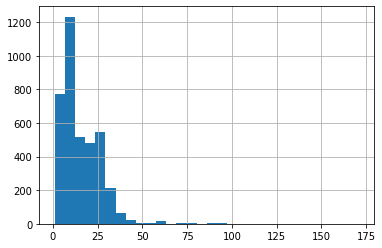

In [52]:
#get the length of all messages in the train data

seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)


We can clearly see that most of the messages have a length of 25 words or less. Whereas the maximum length is 175. So, if we select 175 as the padding length then all the input sequences will have length 175 and most of the tokens in those sequences will be padding tokens which are not going to help the model learn anything useful and on top of that, it will make the training slower.

Therefore, we will set 25 as the padding length.

In [53]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(train_text.tolist(),max_length=25,pad_to_max_length=True,truncation=True)

#tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(val_text.tolist(),max_length=25,pad_to_max_length=True,truncation=True)

#tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(test_text.tolist(),max_length=25,pad_to_max_length=True,truncation=True)



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


So, we have now converted the messages in train, validation, and test set to integer sequences of length 25 tokens each.

Next, we will convert the integer sequences to tensors.

In [54]:
#convert to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())


val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())


test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y=torch.tensor(test_labels.tolist())



Now we will create dataloaders for both train and validation set. These dataloaders will pass batches of train data and validation data as input to the model during the training phase.

In [55]:
from torch.functional import Tensor
from torch.utils.data import TensorDataset , DataLoader , RandomSampler , SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq,train_mask , train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

#dataloader for the trin set
train_dataloader = DataLoader(train_data , sampler=train_sampler , batch_size = batch_size)

#wrap tensors
val_data = TensorDataset(val_seq , val_mask , val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

#dataloader for validation set
val_dataloader = DataLoader(val_data , sampler=val_sampler , batch_size = batch_size)







Define Model Architecture
If you can recall, earlier I mentioned in this article that I would freeze all the layers of the model before fine-tuning it. So, let’s do it first.

In [56]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

This will prevent updating of model weights during fine-tuning. If you wish to fine-tune even the pre-trained weights of the BERT model then you should not execute the code above.

Moving on we will now let’s define our model architecture.

In [57]:
class BERT_Arch(nn.Module):
  def __init__(self,bert):
    super(BERT_Arch,self).__init__()
    self.bert=bert
    self.dropout=nn.Dropout(0.1,)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(768,512)
    self.fc2=nn.Linear(512,2)
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self,send_id,mask):
    _,cls_hs = self.bert(send_id,attention_mask=mask, return_dict=False)
    x=self.fc1(cls_hs)
    x=self.relu(x)
    x=self.dropout(x)
    x=self.fc2(x)
    x=self.softmax(x)
    return x


In [58]:
#pass the pre-trained bert to our define architecture
model = BERT_Arch(bert)

#push the model to GPU
model = model.to(device)


In [59]:
#optimizer from hugging face transformers
from transformers import AdamW

#define the optimizer
optimizer = AdamW(model.parameters(),lr=1e-5)  #learning rate

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


There is a class imbalance in our dataset. The majority of the observations are not spam. So, we will first compute class weights for the labels in the train set and then pass these weights to the loss function so that it takes care of the class imbalance.



In [60]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_labels), y= train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.57743559 3.72848948]


In [61]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

Fine-Tune BERT:

So, till now we have defined the model architecture, we have specified the optimizer and the loss function, and our dataloaders are also ready. Now we have to define a couple of functions to train (fine-tune) and evaluate the model, respectively.

In [62]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

We will use the following function to evaluate the model. It will use the validation set data.



In [63]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

Now we will finally start fine-tuning of the model.



In [64]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.671
Validation Loss: 0.646

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.636
Validation Loss: 0.619

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.611
Validation Loss: 0.587

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.588
Validation Loss: 0.562

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.570
Validation Loss: 0.545

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.548
Validation Loss: 0.520

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.525
Validation Loss: 0.503

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.515
Validat

You can see that the validation loss is still decreasing at the end of the 10th epoch. So, you may try a higher number of epochs. Now let’s see how well it performs on the test dataset.

Make Predictions:

To make predictions, we will first of all load the best model weights which were saved during the training process.

In [65]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

Once the weights are loaded, we can use the fine-tuned model to make predictions on the test set.



In [66]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

Let’s check out the model’s performance.



In [67]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       724
           1       0.45      0.84      0.59       112

    accuracy                           0.84       836
   macro avg       0.71      0.84      0.75       836
weighted avg       0.90      0.84      0.86       836



Both recall and precision for class 1 are quite high which means that the model predicts this class pretty well. However, our objective was to detect spam messages, so misclassifying class 1 (spam) samples is a bigger concern than misclassifying class 0 samples. If you look at the recall for class 1, it is 0.90 which means that the model was able to correctly classify 90% of the spam messages. However, precision is a bit on the lower side for class 1. It means that the model misclassifies some of the class 0 messages (not spam) as spam.